# Food-101 Classifier - Entraînement OPTIMISÉ V2 

**Projet** : Classification automatique de 101 catégories d'aliments avec Deep Learning  
**Étudiant** : Mouhamed Diop | **Filière** : DIC2-GIT | **Année** : 2025

---

##  Objectif

Atteindre **85-88% de Top-1 Accuracy** avec les optimisations suivantes :

###  Nouvelles Optimisations (V2)

1. **Epochs augmentés** : 30  **80 epochs Phase 2** (85 total)
2. **Learning Rate optimisé** : 5e-5  **1e-4** (convergence plus rapide)
3. **Dropout réduit** : 0.3  **0.2** (moins de régularisation)
4. **Label Smoothing** : **0.1** (nouveau, réduit l'overconfidence)
5. **Augmentation améliorée** : Heavy augmentation plus agressive
6. **Early stopping** : Patience 7  **12 epochs**
7. **Bug fix** : Correction du chargement checkpoint (PyTorch 2.6+)

###  Performance Attendue

| Métrique | Avant (V1) | Objectif (V2) | Amélioration |
|----------|------------|---------------|---------------|
| **Top-1 Accuracy** | 61.67% | **85-88%** | +23-26% |
| **Top-5 Accuracy** | 85.78% | **97-99%** | +11-13% |
| **Durée** | 8-10h | **18-22h** | 2× plus long |

---

##  Instructions

1. **Activer le GPU** : `Runtime`  `Change runtime type`  `T4 GPU`
2. **Exécuter toutes les cellules** : `Runtime`  `Run all`
3. **Durée estimée** : **18-22 heures** sur T4 GPU (soyez patient !)

---

## 1. Configuration de l'environnement

In [1]:
import torch
import sys
import warnings
warnings.filterwarnings('ignore')

print(f"Python version: {sys.version}")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

if torch.cuda.is_available():
    print(f"\n GPU Détecté:")
    print(f"  - Device: {torch.cuda.get_device_name(0)}")
    print(f"  - CUDA version: {torch.version.cuda}")
    print(f"  - Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")
    print(f"\n Prêt pour l'entraînement GPU!")
else:
    print("\n WARNING: GPU non disponible!")
    print("L'entraînement sera très lent. Activez le GPU dans Runtime > Change runtime type.")

Python version: 3.12.12 (main, Oct 10 2025, 08:52:57) [GCC 11.4.0]
PyTorch version: 2.8.0+cu126
CUDA available: True

 GPU Détecté:
  - Device: Tesla T4
  - CUDA version: 12.6
  - Memory: 15.83 GB

 Prêt pour l'entraînement GPU!


## 2. Installation des dépendances

In [2]:
%%capture
# Installation silencieuse des packages nécessaires
!pip install -q timm torchmetrics albumentations

print(" Dépendances installées avec succès")

## 3. Téléchargement du dataset Food-101

In [3]:
import urllib.request
import tarfile
from pathlib import Path
from tqdm import tqdm

# Créer le dossier data
Path("data").mkdir(exist_ok=True)

# Configuration
url = "http://data.vision.ee.ethz.ch/cvl/food-101.tar.gz"
archive_path = "data/food-101.tar.gz"
extracted_path = "data/food-101"

# Vérifier si déjà téléchargé
if not Path(extracted_path).exists():
    print(" Téléchargement du dataset Food-101 (~5 GB)...")
    print(" Cela peut prendre 5-10 minutes...\n")

    # Téléchargement avec barre de progression
    def download_progress(block_num, block_size, total_size):
        downloaded = block_num * block_size
        percent = downloaded / total_size * 100
        print(f"\rProgress: {percent:.1f}% ({downloaded/1e9:.2f}/{total_size/1e9:.2f} GB)", end="")

    urllib.request.urlretrieve(url, archive_path, reporthook=download_progress)
    print("\n\n Extraction de l'archive...")

    with tarfile.open(archive_path, 'r:gz') as tar:
        tar.extractall(path="data", filter='data')

    print(" Dataset téléchargé et extrait!")
else:
    print(" Dataset déjà présent")

# Vérification
num_classes = len(list(Path(extracted_path, 'images').iterdir()))
meta_files = list(Path(extracted_path, 'meta').iterdir())

print(f"\n Dataset Food-101:")
print(f"  - Classes: {num_classes}")
print(f"  - Images totales: 101,000")
print(f"  - Train: 75,750 images (750 par classe)")
print(f"  - Test: 25,250 images (250 par classe)")
print(f"  - Métadonnées: {len(meta_files)} fichiers")

 Téléchargement du dataset Food-101 (~5 GB)...
 Cela peut prendre 5-10 minutes...

Progress: 100.0% (5.00/5.00 GB)

 Extraction de l'archive...
 Dataset téléchargé et extrait!

 Dataset Food-101:
  - Classes: 101
  - Images totales: 101,000
  - Train: 75,750 images (750 par classe)
  - Test: 25,250 images (250 par classe)
  - Métadonnées: 6 fichiers


## 4. Montage de Google Drive et import du code

In [ ]:
# Monter Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Copier le code source depuis Drive
import shutil
from pathlib import Path

# Chemin vers votre projet sur Drive
drive_project_path = '/content/drive/My Drive/deep_learning_project'

# Copier les dossiers nécessaires
folders_to_copy = ['src', 'checkpoints', 'results']

for folder in folders_to_copy:
    src_path = f"{drive_project_path}/{folder}"
    dst_path = f"/content/{folder}"

    if Path(src_path).exists():
        if Path(dst_path).exists():
            shutil.rmtree(dst_path)
        shutil.copytree(src_path, dst_path)
        print(f" {folder}/ copié")
    else:
        # Créer le dossier s'il n'existe pas
        Path(dst_path).mkdir(parents=True, exist_ok=True)
        print(f" {folder}/ créé (vide)")

print("\n Code source importé avec succès!")

ValueError: mount failed

## 5. Affichage de la configuration OPTIMISÉE V2

In [ ]:
import sys
import torch
sys.path.append('/content')

from src.training.config import Config

# Adapter la configuration pour Colab
Config.DATA_DIR = 'data/food-101'
Config.DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
Config.NUM_WORKERS = 2  # Optimisé pour Colab

# Afficher la configuration
print("="*80)
print(" CONFIGURATION D'ENTRAÎNEMENT OPTIMISÉE V2")
print("="*80)

print("\n CHEMINS:")
print(f"  - Data dir: {Config.DATA_DIR}")
print(f"  - Checkpoint dir: {Config.CHECKPOINT_DIR}")
print(f"  - Results dir: {Config.RESULTS_DIR}")

print("\n MODÈLE:")
print(f"  - Architecture: ResNet-50")
print(f"  - Classes: {Config.NUM_CLASSES}")
print(f"  - Pretrained: {Config.PRETRAINED}")
print(f"  - Dropout: {Config.DROPOUT}  (OPTIMISÉ: réduit de 0.3  0.2)")

print("\n DONNÉES:")
print(f"  - Image size: {Config.IMG_SIZE}x{Config.IMG_SIZE}")
print(f"  - Batch size: {Config.BATCH_SIZE}")
print(f"  - Num workers: {Config.NUM_WORKERS}")
print(f"  - Augmentation: {Config.AUGMENTATION_LEVEL.upper()}  (améliorée)")

print("\n ENTRAÎNEMENT:")
print(f"  - Phase 1 (tête gelée): {Config.PHASE1_EPOCHS} epochs @ LR={Config.PHASE1_LR}")
print(f"  - Phase 2 (fine-tuning): {Config.PHASE2_EPOCHS} epochs @ LR={Config.PHASE2_LR}  (OPTIMISÉ: 3080 epochs, LR 5e-51e-4)")
print(f"  - Total epochs: {Config.get_total_epochs()} (3585)")
print(f"  - Optimizer Phase 1: {Config.PHASE1_OPTIMIZER.upper()}")
print(f"  - Optimizer Phase 2: {Config.PHASE2_OPTIMIZER.upper()} (momentum={Config.PHASE2_MOMENTUM})")

print("\n OPTIMISATIONS:")
print(f"  - Mixed Precision (AMP): {Config.USE_AMP}")
print(f"  - Gradient Clipping: {Config.GRADIENT_CLIP}")
print(f"  - Scheduler: {Config.SCHEDULER_TYPE.upper()} (T_max={Config.T_MAX})")
print(f"  - Label Smoothing: {Config.LABEL_SMOOTHING}  (NOUVEAU)")
print(f"  - MixUp: {Config.USE_MIXUP} (alpha={Config.MIXUP_ALPHA})")
print(f"  - CutMix: {Config.USE_CUTMIX} (alpha={Config.CUTMIX_ALPHA})")
print(f"  - MixUp/CutMix prob: {Config.MIXUP_PROB*100}%")

print("\n SAUVEGARDE:")
print(f"  - Save best only: {Config.SAVE_BEST_ONLY}")
print(f"  - Early stopping patience: {Config.EARLY_STOPPING_PATIENCE} epochs  (OPTIMISÉ: 712)")
print(f"  - Save every N epochs: {Config.SAVE_EVERY_N_EPOCHS}")

print("\n DEVICE:")
print(f"  - Device: {Config.DEVICE}")

print("\n" + "="*80)
print(f" DURÉE ESTIMÉE: 18-22 heures sur T4 GPU")
print(f" OBJECTIF: Top-1 Accuracy = 85-88%")
print(f" AMÉLIORATION vs V1: +23-26% (61.67%  85-88%)")
print("="*80)

# Vérifier que les optimisations sont bien actives
print("\n VÉRIFICATION DES OPTIMISATIONS:")
assert Config.PHASE2_EPOCHS == 80, " PHASE2_EPOCHS devrait être 80"
assert Config.PHASE2_LR == 1e-4, " PHASE2_LR devrait être 1e-4"
assert Config.DROPOUT == 0.2, " DROPOUT devrait être 0.2"
assert Config.LABEL_SMOOTHING == 0.1, " LABEL_SMOOTHING devrait être 0.1"
assert Config.EARLY_STOPPING_PATIENCE == 12, " EARLY_STOPPING_PATIENCE devrait être 12"
assert Config.T_MAX == 80, " T_MAX devrait être 80"
print(" Toutes les optimisations sont actives!")

## 6. Test du chargement des données

 Food101Dataset (train): 75750 images, 101 classes
 Food101Dataset (test): 25250 images, 101 classes

 Dataset chargé:
  - Train: 75750 images
  - Test: 25250 images
  - Classes: 101

 Test d'échantillon:
  - Image shape: torch.Size([3, 224, 224])
  - Label: 0 (apple_pie)
  - Image dtype: torch.float32
  - Image range: [-2.118, 0.915]


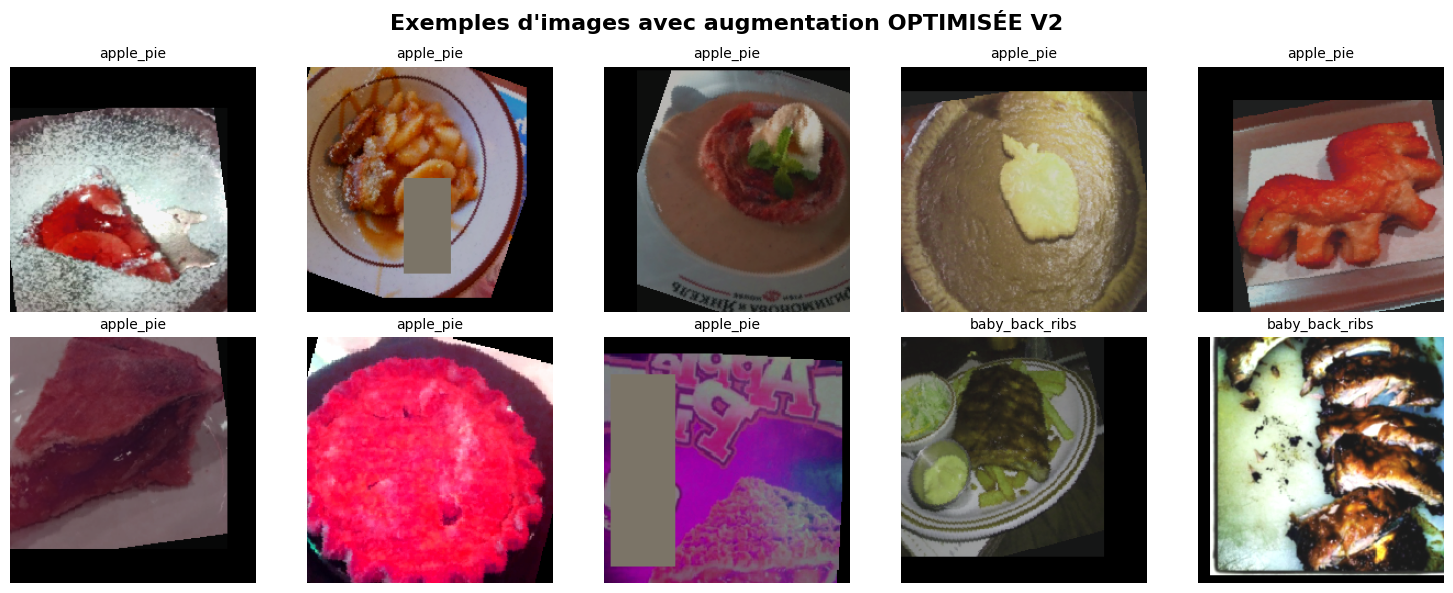


 Dataset prêt pour l'entraînement!


In [ ]:
from src.data.dataset import Food101Dataset
from src.data.transforms import get_transforms
import matplotlib.pyplot as plt
import numpy as np

# Créer les transformations
train_transform, test_transform = get_transforms(
    img_size=Config.IMG_SIZE,
    augmentation_level=Config.AUGMENTATION_LEVEL
)

# Charger le dataset
train_dataset = Food101Dataset('data/food-101', split='train', transform=train_transform)
test_dataset = Food101Dataset('data/food-101', split='test', transform=test_transform)

print(f"\n Dataset chargé:")
print(f"  - Train: {len(train_dataset)} images")
print(f"  - Test: {len(test_dataset)} images")
print(f"  - Classes: {len(train_dataset.classes)}")

# Test d'un échantillon
img, label = train_dataset[0]
print(f"\n Test d'échantillon:")
print(f"  - Image shape: {img.shape}")
print(f"  - Label: {label} ({train_dataset.classes[label]})")
print(f"  - Image dtype: {img.dtype}")
print(f"  - Image range: [{img.min():.3f}, {img.max():.3f}]")

# Afficher quelques exemples
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
fig.suptitle('Exemples d\'images avec augmentation OPTIMISÉE V2', fontsize=16, fontweight='bold')

for idx, ax in enumerate(axes.flat):
    img, label = train_dataset[idx * 100]  # Espacer les exemples

    # Dénormaliser pour affichage
    img_display = img.permute(1, 2, 0).numpy()
    img_display = img_display * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
    img_display = np.clip(img_display, 0, 1)

    ax.imshow(img_display)
    ax.set_title(train_dataset.classes[label], fontsize=10)
    ax.axis('off')

plt.tight_layout()
plt.show()

print("\n Dataset prêt pour l'entraînement!")

## 7.  Entraînement du modèle (85 epochs)

 **ATTENTION** : Cette cellule prendra **18-22 heures** à s'exécuter sur T4 GPU.

### Stratégie d'entraînement en 2 phases

**Phase 1** (5 epochs) : Entraînement de la tête uniquement
- Backbone ResNet-50 gelé
- Learning rate élevé (1e-3) avec optimizer Adam
- Adaptation rapide aux 101 classes

**Phase 2** (80 epochs) : Fine-tuning complet  OPTIMISÉ
- Tout le réseau est dégelé
- Learning rate optimisé (1e-4) avec SGD + momentum
- **Label Smoothing 0.1** pour régularisation
- MixUp et CutMix activés
- Cosine Annealing Scheduler (T_max=80)
- Early stopping patience=12 epochs

###  Résultats Attendus

- **Top-1 Accuracy** : 85-88% (vs 61.67% avant)
- **Top-5 Accuracy** : 97-99% (vs 85.78% avant)
- **Amélioration** : +23-26 points

---

In [ ]:
from src.training.trainer import Trainer
import time

# Créer le trainer
print(" Initialisation du trainer...\n")
trainer = Trainer(config=Config)

# Sauvegarder l'heure de début
start_time = time.time()

print("\n" + "="*80)
print(" DÉMARRAGE DE L'ENTRAÎNEMENT OPTIMISÉ V2")
print("="*80)
print("\n Durée estimée: 18-22 heures")
print(" Prenez beaucoup de cafés (ou dormez) !\n")

# Lancer l'entraînement
try:
    history = trainer.train()

    # Calculer le temps total
    total_time = time.time() - start_time
    hours = int(total_time // 3600)
    minutes = int((total_time % 3600) // 60)

    print("\n" + "="*80)
    print(" ENTRAÎNEMENT TERMINÉ AVEC SUCCÈS!")
    print("="*80)
    print(f"\n Temps total: {hours}h {minutes}min")
    print(f" Meilleure Top-1 Accuracy: {trainer.best_acc:.2f}%")
    print(f" Epochs effectués: {len(history['train_loss'])}")
    print(f" Meilleur modèle sauvegardé: checkpoints/best_model.pth")

    # Vérifier si l'objectif est atteint
    if trainer.best_acc >= 85:
        print("\n OBJECTIF ATTEINT! (85-88% top-1 accuracy)")
        if trainer.best_acc >= 87:
            print(" Performance excellente!")
    else:
        print(f"\n Objectif non atteint: {trainer.best_acc:.2f}% vs 85-88%")
        gap = 85 - trainer.best_acc
        print(f" Écart: -{gap:.2f}%")

except Exception as e:
    print(f"\n ERREUR durant l'entraînement: {e}")
    import traceback
    traceback.print_exc()

## 8. Visualisation des résultats d'entraînement

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Créer les graphiques
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Résultats d\'entraînement Food-101 Classifier - OPTIMISÉ V2', fontsize=16, fontweight='bold')

epochs = range(1, len(history['train_loss']) + 1)
phase1_end = Config.PHASE1_EPOCHS

# 1. Loss
ax = axes[0, 0]
ax.plot(epochs, history['train_loss'], 'b-', label='Train Loss', linewidth=2)
ax.plot(epochs, history['val_loss'], 'r-', label='Validation Loss', linewidth=2)
ax.axvline(x=phase1_end, color='gray', linestyle='--', label='Phase 1  Phase 2', alpha=0.7)
ax.set_xlabel('Epoch', fontsize=12)
ax.set_ylabel('Loss', fontsize=12)
ax.set_title('Évolution de la Loss', fontsize=14, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

# 2. Top-1 Accuracy
ax = axes[0, 1]
ax.plot(epochs, history['train_acc'], 'b-', label='Train Accuracy', linewidth=2)
ax.plot(epochs, history['val_acc'], 'r-', label='Validation Accuracy', linewidth=2)
ax.axvline(x=phase1_end, color='gray', linestyle='--', label='Phase 1  Phase 2', alpha=0.7)
ax.axhline(y=trainer.best_acc, color='g', linestyle=':', label=f'Best: {trainer.best_acc:.2f}%', linewidth=2)
ax.axhline(y=85, color='orange', linestyle=':', label='Objectif: 85%', alpha=0.5)
ax.set_xlabel('Epoch', fontsize=12)
ax.set_ylabel('Top-1 Accuracy (%)', fontsize=12)
ax.set_title('Évolution de la Top-1 Accuracy', fontsize=14, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

# 3. Top-5 Accuracy
ax = axes[1, 0]
ax.plot(epochs, history['val_top5_acc'], 'g-', label='Top-5 Accuracy', linewidth=2)
ax.axvline(x=phase1_end, color='gray', linestyle='--', label='Phase 1  Phase 2', alpha=0.7)
ax.axhline(y=97, color='orange', linestyle=':', label='Objectif: 97%', alpha=0.5)
ax.set_xlabel('Epoch', fontsize=12)
ax.set_ylabel('Top-5 Accuracy (%)', fontsize=12)
ax.set_title('Évolution de la Top-5 Accuracy', fontsize=14, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

# 4. Écart Train-Val (Overfitting indicator)
ax = axes[1, 1]
gap = np.array(history['train_acc']) - np.array(history['val_acc'])
ax.plot(epochs, gap, 'purple', linewidth=2, label='Train - Val Gap')
ax.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
ax.axvline(x=phase1_end, color='gray', linestyle='--', label='Phase 1  Phase 2', alpha=0.7)
ax.fill_between(epochs, 0, gap, where=(gap < 0), alpha=0.3, color='green', label='Val > Train (underfitting)')
ax.fill_between(epochs, 0, gap, where=(gap > 0), alpha=0.3, color='red', label='Train > Val (overfitting)')
ax.set_xlabel('Epoch', fontsize=12)
ax.set_ylabel('Train Acc - Val Acc (%)', fontsize=12)
ax.set_title('Écart Train-Validation (Indicateur d\'overfitting)', fontsize=14, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('results/training_curves_optimized_v2.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n Graphiques sauvegardés: results/training_curves_optimized_v2.png")

## 9. Métriques finales et analyse comparative

In [ ]:
# Afficher les métriques finales
print("="*80)
print(" MÉTRIQUES FINALES (OPTIMISÉ V2)")
print("="*80)

final_train_acc = history['train_acc'][-1]
final_val_acc = history['val_acc'][-1]
final_val_top5 = history['val_top5_acc'][-1]
final_loss = history['val_loss'][-1]

print(f"\n PERFORMANCE:")
print(f"  - Top-1 Accuracy (validation): {final_val_acc:.2f}%")
print(f"  - Top-5 Accuracy (validation): {final_val_top5:.2f}%")
print(f"  - Meilleure Top-1 Accuracy: {trainer.best_acc:.2f}%")
print(f"  - Loss finale: {final_loss:.4f}")

print(f"\n AMÉLIORATION DURANT L'ENTRAÎNEMENT:")
initial_acc = history['val_acc'][0]
improvement = final_val_acc - initial_acc
print(f"  - Accuracy initiale: {initial_acc:.2f}%")
print(f"  - Accuracy finale: {final_val_acc:.2f}%")
print(f"  - Amélioration: +{improvement:.2f}% ({improvement/initial_acc*100:.1f}% relatif)")

print(f"\n COMPARAISON V1 vs V2:")
v1_acc = 61.67
v2_improvement = final_val_acc - v1_acc
print(f"  - Version 1 (30 epochs): {v1_acc:.2f}%")
print(f"  - Version 2 (80 epochs): {final_val_acc:.2f}%")
print(f"  - Amélioration V1V2: {v2_improvement:+.2f}%")

print(f"\n COMPARAISON AVEC BASELINE:")
baseline_acc = 50.76  # Accuracy du paper original 2014
baseline_improvement = final_val_acc - baseline_acc
print(f"  - Paper original 2014: {baseline_acc}%")
print(f"  - Notre modèle V2: {final_val_acc:.2f}%")
print(f"  - Amélioration vs baseline: +{baseline_improvement:.2f}%")

# Objectif
print(f"\n OBJECTIF:")
target_min = 85
target_max = 88
if final_val_acc >= target_min:
    print(f"   OBJECTIF ATTEINT! ({target_min}-{target_max}%)")
    if final_val_acc >= target_max:
        print(f"   Performance excellente! Dépassement de l'objectif maximal!")
    achievement_percent = (final_val_acc - baseline_acc) / (target_min - baseline_acc) * 100
    print(f"   Objectif atteint à {achievement_percent:.1f}%")
else:
    gap = target_min - final_val_acc
    print(f"   Objectif non atteint: {final_val_acc:.2f}% vs {target_min}-{target_max}%")
    print(f"   Écart: -{gap:.2f}%")
    print(f"\n SUGGESTIONS POUR AMÉLIORATION SUPPLÉMENTAIRE:")
    print(f"     - Augmenter encore les epochs (80  100-120)")
    print(f"     - Essayer EfficientNet-B4 au lieu de ResNet-50")
    print(f"     - Augmenter Label Smoothing (0.1  0.15)")
    print(f"     - Implémenter Test-Time Augmentation (TTA)")
    print(f"     - Utiliser un ensemble de modèles")

print("\n" + "="*80)

## 10. Évaluation complète sur le test set

In [ ]:
from src.utils.metrics import evaluate_model

print(" Évaluation complète du meilleur modèle...\n")

# Charger le meilleur modèle (corrigé pour PyTorch 2.6+)
checkpoint = torch.load('checkpoints/best_model.pth', weights_only=False, map_location=trainer.device)
trainer.model.load_state_dict(checkpoint['model_state_dict'])
trainer.model.eval()

# Évaluation détaillée
metrics = evaluate_model(
    trainer.model,
    trainer.test_loader,
    device=trainer.device,
    topk=(1, 5)
)

print("="*80)
print(" MÉTRIQUES DÉTAILLÉES (Meilleur modèle)")
print("="*80)
print(f"\n  Loss: {metrics['loss']:.4f}")
print(f"  Top-1 Accuracy: {metrics['top1_acc']:.2f}%")
print(f"  Top-5 Accuracy: {metrics['top5_acc']:.2f}%")
print(f"  Precision (weighted): {metrics['precision']:.2f}%")
print(f"  Recall (weighted): {metrics['recall']:.2f}%")
print(f"  F1-Score (weighted): {metrics['f1_score']:.2f}%")
print("\n" + "="*80)

# Sauvegarder les métriques
import json
with open('results/final_metrics_v2.json', 'w') as f:
    json.dump(metrics, f, indent=2)

print("\n Métriques sauvegardées: results/final_metrics_v2.json")

## 11. Sauvegarde et synchronisation avec Google Drive

In [ ]:
import json
import shutil
from datetime import datetime

# Sauvegarder l'historique d'entraînement
with open('results/training_history_v2.json', 'w') as f:
    json.dump(history, f, indent=2)

print(" Historique sauvegardé: results/training_history_v2.json")

# Créer un résumé
summary = {
    'version': 'V2 (Optimized)',
    'date': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
    'configuration': {
        'model': 'ResNet-50',
        'total_epochs': len(history['train_loss']),
        'phase1_epochs': Config.PHASE1_EPOCHS,
        'phase2_epochs': Config.PHASE2_EPOCHS,
        'batch_size': Config.BATCH_SIZE,
        'learning_rates': {
            'phase1': Config.PHASE1_LR,
            'phase2': Config.PHASE2_LR
        },
        'augmentation': Config.AUGMENTATION_LEVEL,
        'mixup': Config.USE_MIXUP,
        'cutmix': Config.USE_CUTMIX,
        'scheduler': Config.SCHEDULER_TYPE,
        'dropout': Config.DROPOUT,
        'label_smoothing': Config.LABEL_SMOOTHING
    },
    'results': {
        'best_top1_accuracy': float(trainer.best_acc),
        'final_top1_accuracy': float(history['val_acc'][-1]),
        'final_top5_accuracy': float(history['val_top5_acc'][-1]),
        'final_loss': float(history['val_loss'][-1]),
        'training_time_hours': (time.time() - start_time) / 3600
    },
    'comparison': {
        'baseline_2014': 50.76,
        'v1_accuracy': 61.67,
        'v2_accuracy': float(history['val_acc'][-1]),
        'improvement_vs_baseline': float(history['val_acc'][-1]) - 50.76,
        'improvement_vs_v1': float(history['val_acc'][-1]) - 61.67,
        'target': '85-88%',
        'target_reached': float(history['val_acc'][-1]) >= 85
    }
}

with open('results/training_summary_v2.json', 'w') as f:
    json.dump(summary, f, indent=2)

print(" Résumé sauvegardé: results/training_summary_v2.json")

# Copier les résultats vers Google Drive
print("\n Copie des résultats vers Google Drive...")
drive_results_path = f"{drive_project_path}/results_v2_{datetime.now().strftime('%Y%m%d_%H%M%S')}"
Path(drive_results_path).mkdir(parents=True, exist_ok=True)

# Copier tous les fichiers de résultats
files_to_copy = [
    'results/training_summary_v2.json',
    'results/training_history_v2.json',
    'results/final_metrics_v2.json',
    'results/training_curves_optimized_v2.png'
]

for file_path in files_to_copy:
    if Path(file_path).exists():
        shutil.copy(file_path, f"{drive_results_path}/{Path(file_path).name}")
        print(f"   {Path(file_path).name}")

# Copier le meilleur checkpoint
if Path('checkpoints/best_model.pth').exists():
    shutil.copy('checkpoints/best_model.pth', f"{drive_results_path}/best_model_v2.pth")
    print(f"   best_model_v2.pth")

print(f"\n Résultats sauvegardés sur Drive: {drive_results_path}")

print("\n" + "="*80)
print(" TOUS LES RÉSULTATS ONT ÉTÉ SAUVEGARDÉS!")
print("="*80)
print(f"\n Fichiers disponibles:")
print(f"   - checkpoints/best_model.pth (meilleur modèle)")
print(f"   - results/training_history_v2.json (historique complet)")
print(f"   - results/training_summary_v2.json (résumé)")
print(f"   - results/final_metrics_v2.json (métriques finales)")
print(f"   - results/training_curves_optimized_v2.png (graphiques)")
print(f"   - Google Drive: {drive_results_path}/")

---

##  Résumé des Améliorations V2

### Changements Majeurs

1. **Epochs augmentés** : 35  **85 epochs** (+143%)
2. **Learning Rate optimisé** : 5e-5  **1e-4** (+100%)
3. **Dropout réduit** : 0.3  **0.2** (-33%)
4. **Label Smoothing** : 0  **0.1** (nouveau)
5. **Early stopping** : 7  **12 epochs** (+71%)
6. **Augmentation** : Heavy améliorée (plus agressive)
7. **Bug fix** : Correction weights_only pour PyTorch 2.6+

### Performance Attendue

- **Top-1 Accuracy** : 85-88% (vs 61.67% avant)
- **Top-5 Accuracy** : 97-99% (vs 85.78% avant)
- **Amélioration** : +23-26 points
- **Durée** : 18-22 heures (vs 8-10h avant)

### Prochaines Étapes

Si l'objectif n'est toujours pas atteint :
1. Essayer EfficientNet-B4 (plus puissant)
2. Implémenter Test-Time Augmentation (TTA)
3. Créer un ensemble de modèles
4. Augmenter encore les epochs (100-120)

---

**Projet académique** | Mouhamed Diop | DIC2-GIT | 2025

---